# 6章 一元配置分散分析・多重比較

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(readr)
library(gridExtra)
library(Cairo)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



## 6.1 t検定の繰り返しは誤り

## 6.2 一元配置分散分析: 原理

## 6.3 Rで計算

In [2]:
d.stron <- data_frame(
    stron = c(28.2, 33.2, 36.4, 34.6, 29.1, 31.0, 
              39.6, 40.8, 37.9, 37.1, 43.6, 42.4, 
              46.3, 42.1, 43.5, 48.8, 43.7, 40.1, 
              41.0, 44.1, 46.4, 40.2, 38.6, 36.3, 
              56.3, 54.1, 59.4, 62.7, 60.0, 57.3), 
    lake = factor(sort(rep(1:5, 6)))
)
head(d.stron)

stron,lake
28.2,1
33.2,1
36.4,1
34.6,1
29.1,1
31.0,1


In [3]:
aov(stron ~ lake, data = d.stron) %>% summary()

            Df Sum Sq Mean Sq F value   Pr(>F)    
lake         4 2193.4   548.4   56.16 3.95e-12 ***
Residuals   25  244.1     9.8                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

手動計算

* `m`: 群の総数
* `n`: 各群の標本サイズ
* `SS.b`: 群間平方和
* `SS.w`: 群内平方和
* `MS.b`, `MS.w`: 平均平方

In [4]:
(function(){
    m <- d.stron$stron %>% mean()
    
    SS.b <- d.stron %>% group_by(lake) %>% summarise_all(funs(stron = mean, n = n())) %>% 
        mutate(x = n * (stron - m)^2) %>% summarise(SS.b = sum(x)) %>% .[["SS.b"]]
    SS.w <- d.stron %>% group_by(lake) %>% mutate(x = (stron - mean(stron))^2) %>% 
        summarise_all(funs(sum)) %>% summarise(SS.w = sum(x)) %>% .[["SS.w"]]
    
    df_b <- d.stron$lake %>% unique %>% length %>% {. - 1}
    df_w <- d.stron %>% group_by(lake) %>% summarise(n = n()) %>% 
        summarise(df_w = sum(n - 1)) %>% .[["df_w"]]
    
    MS.b <- SS.b / df_b
    MS.w <- SS.w / df_w
    F_val <- MS.b / MS.w
    p_val <- 1 - pf(F_val, df_b, df_w)
    
    return(list("F_val" = F_val, "p_val" = p_val))
})()

$F_val
[1] 56.15456

$p_val
[1] 3.947953e-12

In [5]:
d.pig <- data_frame(
    f1 = c(60.8, 57.0, 65.0, 58.6, 61.7),
    f2 = c(68.7, 67.7, 74.0, 66.3, 69.8), 
    f3 = c(102.6, 102.1, 100.2, 96.5, NA), 
    f4 = c(87.9, 84.2, 83.1, 85.7, 90.3)
)
d.pig

f1,f2,f3,f4
60.8,68.7,102.6,87.9
57.0,67.7,102.1,84.2
65.0,74.0,100.2,83.1
58.6,66.3,96.5,85.7
61.7,69.8,NA,90.3


In [6]:
d.pig %>% gather(feed, Pig) %>% aov(Pig ~ feed, data = .) %>% summary()

            Df Sum Sq Mean Sq F value   Pr(>F)    
feed         3   4226  1408.8   164.6 1.06e-11 ***
Residuals   15    128     8.6                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
1 observation deleted due to missingness

### Tuket HSD

In [7]:
aov(stron ~ lake, data = d.stron) %>% summary()

            Df Sum Sq Mean Sq F value   Pr(>F)    
lake         4 2193.4   548.4   56.16 3.95e-12 ***
Residuals   25  244.1     9.8                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

標準誤差 SE は，

$SE = \sqrt{\frac{残差MS}{n}}$

In [9]:
sqrt(9.8 / 6)

[1] 1.278019

統計量 $q$ は，5 と 1とでは，

$|q| = \frac{\bar{X}_5 - \bar{X}_1}{SE}$

In [8]:
aov(stron ~ lake, data = d.stron) %>% TukeyHSD()

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = stron ~ lake, data = d.stron)

$lake
          diff       lwr       upr     p adj
2-1  8.1500000  2.851355 13.448645 0.0011293
3-1 12.0000000  6.701355 17.298645 0.0000053
4-1  9.0166667  3.718021 14.315312 0.0003339
5-1 26.2166667 20.918021 31.515312 0.0000000
3-2  3.8500000 -1.448645  9.148645 0.2376217
4-2  0.8666667 -4.431979  6.165312 0.9884803
5-2 18.0666667 12.768021 23.365312 0.0000000
4-3 -2.9833333 -8.281979  2.315312 0.4791100
5-3 14.2166667  8.918021 19.515312 0.0000003
5-4 17.2000000 11.901355 22.498645 0.0000000


* スチューデント化されたq とは?

In [84]:
d.stron %>% group_by(lake) %>% summarise_each(funs(mean)) %>% 
    {
        l <- list()
        for(i in 1:5){
            l[[.$lake[i]]] = .$stron[i]
        }
        comb <- combn(.$lake, 2)
        for (i in 1:ncol(comb)){
            xy <- comb[,i]
            cat(xy[1], "-", xy[2], ": ", (l[[xy[1]]] - l[[xy[2]]]), "\n")
        }
    }

1 - 2 :  -8.15 
1 - 3 :  -12 
1 - 4 :  -9.016667 
1 - 5 :  -26.21667 
2 - 3 :  -3.85 
2 - 4 :  -0.8666667 
2 - 5 :  -18.06667 
3 - 4 :  2.983333 
3 - 5 :  -14.21667 
4 - 5 :  -17.2 


## 多重比較

* 検定の多重性
    * 有意水準の調整
* 事前比較，事後比較

種類

* Tukey-Kramer
* Dunnett
* Scheffe
* Williams

### 6.4.1 Tukey-Kramer

* 表6.7（微妙に値が違う）

In [64]:
d <- read_csv("../samplecode/Rで学ぶ統計学入門図版作成用/table6-5.csv") 
head(d)

Parsed with column specification:
cols(
  score = col_integer(),
  group = col_character()
)


score,group
14,g1
17,g1
16,g1
15,g1
17,g1
16,g1


In [65]:
aov(score ~ factor(group), data=d) %>% summary()

              Df Sum Sq Mean Sq F value   Pr(>F)    
factor(group)  3  80.28  26.759   10.61 9.81e-05 ***
Residuals     26  65.59   2.523                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [66]:
aov(score ~ factor(group), data=d)

Call:
   aov(formula = score ~ factor(group), data = d)

Terms:
                factor(group) Residuals
Sum of Squares       80.27738  65.58929
Deg. of Freedom             3        26

Residual standard error: 1.58829
Estimated effects may be unbalanced

In [67]:
aov(score ~ factor(group), data=d) %>% TukeyHSD()

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = score ~ factor(group), data = d)

$`factor(group)`
           diff        lwr      upr     p adj
g2-g1 0.7142857 -1.6147288 3.043300 0.8342852
g3-g1 2.3571429  0.1020842 4.612201 0.0380588
g4-g1 4.2321429  1.9770842 6.487201 0.0001269
g3-g2 1.6428571 -0.6122015 3.897916 0.2143839
g4-g2 3.5178571  1.2627985 5.772916 0.0012127
g4-g3 1.8750000 -0.3035936 4.053594 0.1102113


g1 と g2 が逆

In [68]:
d %>% tibble::rownames_to_column() %>% spread(group, score) %>% select(-1) %>% sapply(function(x){
    na.omit(x)
})

$g1
[1] 14 17 16 15 17 16 18
attr(,"na.action")
 [1]  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 24 29 30
attr(,"class")
[1] "omit"

$g2
[1] 17 15 19 19 17 15 16
attr(,"na.action")
 [1]  1  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
attr(,"class")
[1] "omit"

$g3
[1] 16 18 19 17 20 19 18 21
attr(,"na.action")
 [1]  1  2  3  4  5  6 12 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
attr(,"class")
[1] "omit"

$g4
[1] 21 20 18 19 22 23 21 19
attr(,"na.action")
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 23 25 26 27 28 29 30
attr(,"class")
[1] "omit"

In [73]:
d %>% mutate(group = case_when(.$group == "g1" ~ "g2", 
                              .$group == "g2" ~ "g1", 
                              TRUE ~ .$group)) -> d

In [74]:
aov(score ~ factor(group), data = d) %>% TukeyHSD()

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = score ~ factor(group), data = d)

$`factor(group)`
            diff        lwr      upr     p adj
g2-g1 -0.7142857 -3.0433003 1.614729 0.8342852
g3-g1  1.6428571 -0.6122015 3.897916 0.2143839
g4-g1  3.5178571  1.2627985 5.772916 0.0012127
g3-g2  2.3571429  0.1020842 4.612201 0.0380588
g4-g2  4.2321429  1.9770842 6.487201 0.0001269
g4-g3  1.8750000 -0.3035936 4.053594 0.1102113


In [75]:
options(repr.plot.width = 3, repr.plot.height = 3)

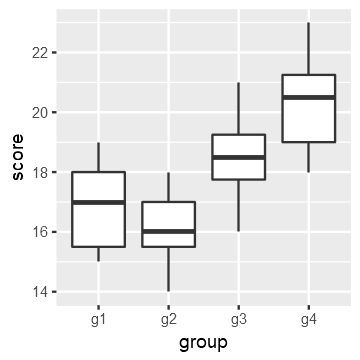

In [84]:
d %>% ggplot(aes(x = group, y = score)) + geom_boxplot()

### 6.4.2 Dunnett

表6.8

In [85]:
d2 <- read_csv("../samplecode/Rで学ぶ統計学入門図版作成用/table6-6.csv")
head(d2)

Parsed with column specification:
cols(
  score = col_integer(),
  group = col_character()
)


score,group
7,C
9,C
8,C
6,C
9,C
8,C


In [86]:
str(d2)

Classes 'tbl_df', 'tbl' and 'data.frame':	34 obs. of  2 variables:
 $ score: int  7 9 8 6 9 8 11 10 8 8 ...
 $ group: chr  "C" "C" "C" "C" ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 2
  .. ..$ score: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ group: list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


In [91]:
d2 %>% tibble::rownames_to_column("id") %>% spread(group, score) %>% select(-id) %>% sapply(function(x){
    na.omit(x)
})

$C
 [1]  7  8  9  8  6  9  8 11 10  8
attr(,"na.action")
 [1]  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 24 25 26 27 28
attr(,"class")
[1] "omit"

$g2
[1]  8  9 10  8  9  9 10 12
attr(,"na.action")
 [1]  1  2 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
[26] 34
attr(,"class")
[1] "omit"

$g3
[1] 11 12 12 10 11 13  9 10
attr(,"na.action")
 [1]  1  2  3  4  5  6  7  8  9 10 12 20 21 22 23 24 25 26 27 28 29 30 31 32 33
[26] 34
attr(,"class")
[1] "omit"

$g4
[1] 13 12 12 11 14 12 11 10
attr(,"na.action")
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 29 30 31 32 33
[26] 34
attr(,"class")
[1] "omit"

In [98]:
library(multcomp)

Warning message:
"package 'multcomp' was built under R version 3.3.3"Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Warning message:
"package 'TH.data' was built under R version 3.3.3"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'TH.data'

The following object is masked from 'package:MASS':

    geyser



In [102]:
detach(package:multcomp)

In [103]:
detach(package:TH.data)

In [104]:
detach(package:MASS)

In [105]:
select

function (.data, ...) 
{
    select_(.data, .dots = lazyeval::lazy_dots(...))
}
<environment: namespace:dplyr>

In [106]:
d2 %>% 
    mutate(group = factor(group)) %>% 
    aov(score ~ group, data=.) %>% 
    multcomp::glht(linfct=multcomp::mcp(group="Dunnett")) %>% summary()


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Dunnett Contrasts


Fit: aov(formula = score ~ group, data = .)

Linear Hypotheses:
            Estimate Std. Error t value Pr(>|t|)    
g2 - C == 0   0.9750     0.6314   1.544    0.309    
g3 - C == 0   2.6000     0.6314   4.118   <0.001 ***
g4 - C == 0   3.4750     0.6314   5.504   <0.001 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)


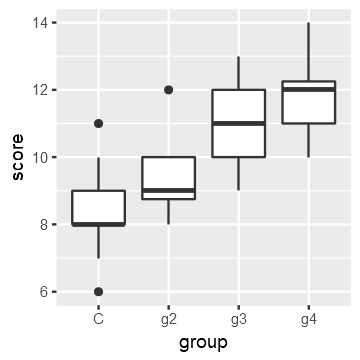

In [108]:
d2 %>% ggplot(aes(x = group, y = score)) + geom_boxplot()

### 6.4.3 Bonferroni (Holm)

表6.9

In [109]:
d3 <- read_csv("../samplecode/Rで学ぶ統計学入門図版作成用/table6-7.csv")
head(d3)

Parsed with column specification:
cols(
  score = col_integer(),
  group = col_character()
)


score,group
58,g1
52,g1
72,g1
60,g1
67,g1
62,g2


In [110]:
d3 %>% tibble::rownames_to_column("id") %>% spread(group, score) %>% select(-id) %>% sapply(function(x){
    na.omit(x)
})

$g1
[1] 58 52 72 60 67
attr(,"na.action")
 [1]  2  3  4  5  6  7  8  9 10 11 13 14 15 19 20 21 22
attr(,"class")
[1] "omit"

$g2
[1] 60 62 53 74 69
attr(,"na.action")
 [1]  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
attr(,"class")
[1] "omit"

$g3
[1] 65 62 69 75 84 79
attr(,"na.action")
 [1]  1  2  9 10 11 12 13 14 15 16 17 18 19 20 21 22
attr(,"class")
[1] "omit"

$g4
[1] 77 72 83 81 91 83
attr(,"na.action")
 [1]  1  2  3  4  5  6  7  8 12 16 17 18 19 20 21 22
attr(,"class")
[1] "omit"

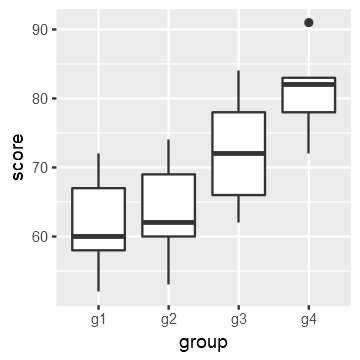

In [115]:
d3 %>% ggplot(aes(group, score)) + geom_boxplot()

表6.7 のデータ

In [113]:
d %>% {pairwise.t.test(.$score, .$group, p.adj = "holm")}


	Pairwise comparisons using t tests with pooled SD 

data:  .$score and .$group 

   g1      g2      g3     
g2 0.40782 -       -      
g3 0.11243 0.03239 -      
g4 0.00112 0.00014 0.07800

P value adjustment method: holm 

表6.9 のデータ

In [114]:
d3 %>% {pairwise.t.test(.$score, .$group, p.adj = "holm")}


	Pairwise comparisons using t tests with pooled SD 

data:  .$score and .$group 

   g1     g2     g3    
g2 0.7169 -      -     
g3 0.1482 0.1894 -     
g4 0.0037 0.0072 0.1894

P value adjustment method: holm 

In [116]:
ls()

[1] "d"       "d.pig"   "d.stron" "d2"      "d3"      "f"

## 演習問題
### ex. 6.1

In [117]:
str(d.pig)

Classes 'tbl_df', 'tbl' and 'data.frame':	5 obs. of  4 variables:
 $ f1: num  60.8 57 65 58.6 61.7
 $ f2: num  68.7 67.7 74 66.3 69.8
 $ f3: num  102.6 102.1 100.2 96.5 NA
 $ f4: num  87.9 84.2 83.1 85.7 90.3


Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."

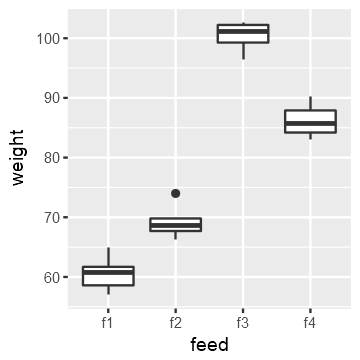

In [123]:
d.pig %>% gather(feed, weight) %>% ggplot(aes(feed, weight)) + geom_boxplot()

In [120]:
d.pig %>% gather(feed, weight) %>% aov(weight ~ factor(feed), data=.) %>% TukeyHSD()

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = weight ~ factor(feed), data = .)

$`factor(feed)`
        diff        lwr       upr     p adj
f2-f1   8.68   3.347895 14.012105 0.0014725
f3-f1  39.73  34.074449 45.385551 0.0000000
f4-f1  25.62  20.287895 30.952105 0.0000000
f3-f2  31.05  25.394449 36.705551 0.0000000
f4-f2  16.94  11.607895 22.272105 0.0000009
f4-f3 -14.11 -19.765551 -8.454449 0.0000168


In [121]:
d.pig %>% gather(feed, weight) %>% {pairwise.t.test(.$weight, .$feed, p.adj = "holm")}


	Pairwise comparisons using t tests with pooled SD 

data:  .$weight and .$feed 

   f1      f2      f3     
f2 0.00029 -       -      
f3 1.6e-11 4.6e-10 -      
f4 2.4e-09 4.7e-07 6.2e-06

P value adjustment method: holm 

### ex. 6.2

In [124]:
str(d3)

Classes 'tbl_df', 'tbl' and 'data.frame':	22 obs. of  2 variables:
 $ score: int  58 52 72 60 67 62 53 74 69 60 ...
 $ group: chr  "g1" "g1" "g1" "g1" ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 2
  .. ..$ score: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ group: list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


In [126]:
d3 %>% 
    mutate(group = if_else(group == "g1", "C", group)) %>% 
    mutate(group = factor(group)) %>% 
    aov(score ~ group, data=.) %>% 
    multcomp::glht(linfct=multcomp::mcp(group="Dunnett")) %>% summary()


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Dunnett Contrasts


Fit: aov(formula = score ~ group, data = .)

Linear Hypotheses:
            Estimate Std. Error t value Pr(>|t|)   
g2 - C == 0    1.800      4.886   0.368  0.96524   
g3 - C == 0   10.533      4.678   2.252  0.09025 . 
g4 - C == 0   19.367      4.678   4.140  0.00167 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)


In [128]:
d3 %>% 
    mutate(group = if_else(group == "g1", "C", group)) %>% 
    {pairwise.t.test(.$score, .$group, p.adj = "holm")}


	Pairwise comparisons using t tests with pooled SD 

data:  .$score and .$group 

   C      g2     g3    
g2 0.7169 -      -     
g3 0.1482 0.1894 -     
g4 0.0037 0.0072 0.1894

P value adjustment method: holm 

In [69]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.2 (2016-10-31)
 system   x86_64, mingw32             
 ui       RTerm                       
 language en_US.UTF-8                 
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2017-05-21                  

 package    * version    date       source                            
 assertthat   0.2.0      2017-04-11 CRAN (R 3.3.2)                    
 Cairo      * 1.5-9      2015-09-26 CRAN (R 3.2.2)                    
 colorspace   1.3-2      2016-12-14 CRAN (R 3.3.3)                    
 crayon       1.3.2      2016-06-28 CRAN (R 3.3.1)                    
 DBI          0.6-1      2017-04-01 CRAN (R 3.3.3)                    
 devtools     1.12.0     2016-06-24 CRAN (R 3.3.1)                    
 digest       0.6.12     2017-01-27 CRAN (R 3.3.3)                    
 dplyr      * 0.5.0      2016-06-24 CRAN (R 3.2.5)                    
 evaluate     0.10       2016-10-11 CRAN (R 3.3.